In [1]:
import plumed
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1977) # makes notebook reproducible

In [2]:
kBT=1.2388545199729883 * 2

In [3]:
# This is the main run
colvar_rew=plumed.read_as_pandas("COLVAR_REWEIGHT")

<ipython-input-3-2bb0f66518b4>:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  colvar_rew=plumed.read_as_pandas("COLVAR_REWEIGHT")


In [4]:
colvar_rew

,time,lambda,metad.bias
0,0.0,0.0,732.582378
1,1.0,0.0,732.582378
2,2.0,0.0,732.582378
3,3.0,2.0,732.481424
4,4.0,1.0,732.332809
...,...,...,...
249996,249996.0,0.0,732.582378
249997,249997.0,1.0,732.332809
249998,249998.0,0.0,732.582378
249999,249999.0,0.0,732.582378


## 1. Functions for free energy calculations

In [5]:
def analyze(traj, n_blocks, discard=0):
    """
    This function returns average and error with bootstrap
    
    Parameters
    ----------
    traj (pandas.DataFrame): trajectory data (content of COLVAR)
    nblocks (int): number of blocks
    discard (float): discarded fraction
    """
    n = int(len(traj) * (1.0 - discard))   # number of data points considered
    # make sure the number of frames is a multiple of nblocks (discard the first few frames)
    n = (n // n_blocks) * n_blocks
    bias = np.array(traj["metad.bias"])
    bias -= np.max(bias) # avoid overflows
    w = np.exp(bias / kBT)[-n:].reshape((n_blocks, -1)) # shape: (nblocks, nframes in one block), weight for each point
    
    # A: coupled state, B: uncoupled state
    isA = np.int_(traj["lambda"] == 0)[-n:].reshape((n_blocks, -1)) # 1 if in A (np.in_ converts bool to 0 or 1)
    isB = np.int_(traj["lambda"] == np.max(traj["lambda"]))[-n:].reshape((n_blocks, -1)) # 1 if in B
    
    B = 200 # number of bootstrap iterations
    boot = np.random.choice(n_blocks, size=(B, n_blocks))  # draw samples from np.arange(n_blocks), size refers the output size
    popA = np.average(isA[boot], axis=(1,2), weights=w[boot])  # Note that isA[boot] is a 3D array
    popB = np.average(isB[boot], axis=(1,2), weights=w[boot])  # shapes of popA and popB: (B,)

    df = np.log(popA / popB) # this is in kBT units
    popA0 = np.average(isA, weights=w)
    popB0 = np.average(isB, weights=w)
    return np.log(popA0 / popB0), np.std(df)

Notes about the function `analyze`:
- The shape of `w` is `(n_blocks, n_frames)`, where `n_blocks` and `n_frames` are the number of blocks and the number of frames in one block. It contains the weight for each frame in each block.
- In each bootstrap iteration, 1000 blocks were chosen (index 0 to 999) with replacement. 
- `isA[boot]` is a 3D array. For exampl, given 200 bootstrap iterations and 1000 blocks (50 frames in each block), the shape of `isA[boot]` is (200, 1000, 50). Averging such an array along axis (1, 2) gives the average weighted histogram counts for each bootstrap, so the array returned will have a shape of (200,).
- Below is an example of averaging along different axes:
```
x = np.array([[[1,2], [1,1]],
              [[1,1], [2,1]],
              [[1,0], [0,0]]])
print(f'The shape of x: {x.shape}: \n')
print(f'Averaging along axis 1:  \n{np.average(x, axis=1)}\n')
print(f'Averaging along axis 2: \n {np.average(x, axis=2)} \n')
print(f'Averaging along axis (1, 2): \n {np.average(x, axis=(1,2))} \n')
```
And here are the results:

```
The shape of x: (3, 2, 2): 

Averaging along axis 1:  
[[1.  1.5]
 [1.5 1. ]
 [0.5 0. ]]

Averaging along axis 2: 
 [[1.5 1. ]
 [1.  1.5]
 [0.5 0. ]] 

Averaging along axis (1, 2): 
 [1.25 1.25 0.25] 
```
- `df` has a shape of (B,). It is free energy difference between the coupled state (A) and the uncoupled state (B) calculated for each bootstrap. From this array we could calculate the error of the free energy difference, which is the standard deviation of the bootstrap samples. To calculate the final free energy difference, we average all the frames. Note that this is different from averaging the bootstrap samples evenly. 

In [6]:
# time-averaged potential, computed averaging over the final 25%
def time_average(hills, t0=0.75):
    n0 = int(len(hills) * t0)   # number of data points considered
    w = np.hstack((np.ones(n0), np.linspace(1, 0, len(hills) - n0)))  # the weights for the first n0 points are 1
    hills = hills.copy()
    hills.height *= w
    return hills

Notes about the function `time_average`:
```
g(4001) = g1 +g2 +g3 + g4 + . . . + g4001
g(4002) = g1 +g2 +g3 + g4 + . . . + g4001 + g4002
g(4003) = g1 +g2 +g3 + g4 + . . . + g4001 + g4002 + g4003 
      . . . 
g(5000) = g1 +g2 +g3 + g4 + . . . + g4001 + g4002 + g4003 + g4004 . . . 

Average of [g(4001), g(4002), ..., g(5000)] is  
= (1/1000) (1000g1+ 1000g2 + 1000g3 +  999 g4001 + 998 g4002 + 997 g4003 . . . . 2 g4999 + g5000 ) 
= (g1 + g2 +g3  + . . . + g4001) + 999/1000 g4001 + 998/1000 g4002 + 2/1000 g4000 + 1/1000 g5000
```

In [7]:
# bias potential computed from hills
# can be used to recompute V(lambda) given the hills file
# can be used on a hills file produced by time_average()
# the result is an array with V for each lambda index
def metad_bias(hills):
    bias=[]
    for i in range(np.max(hills["lambda"] + 1)):
        bias.append(np.sum(np.array(hills["lambda"] == i, dtype=int) * hills["height"] / hills["biasf"] * (hills["biasf"] - 1)))
    return np.array(bias)

## 2. Data analysis

In [8]:
# block analysis
dd = []
nblocks = [100000, 50000, 20000, 10000, 5000, 2000, 1000, 500, 200, 100, 50, 20, 10, 5]
for nb in nblocks:
    dd.append(analyze(colvar_rew, nb, discard=0.0))
dd=np.array(dd)
dd   # free energy difference and its uncertainty given different block sizes

array([[-3.20500138,  0.00869569],
       [-3.20067554,  0.01011054],
       [-3.20320949,  0.01512304],
       [-3.20067554,  0.02194774],
       [-3.20067554,  0.02983902],
       [-3.20067554,  0.04145926],
       [-3.20067554,  0.05008426],
       [-3.20067554,  0.05960733],
       [-3.20067554,  0.06582666],
       [-3.20067554,  0.06156457],
       [-3.20067554,  0.05197067],
       [-3.20067554,  0.03829368],
       [-3.20067554,  0.0172728 ],
       [-3.20067554,  0.00455241]])

In [25]:
len(colvar_rew)/ np.array(nblocks) *0.02

array([5.000020e-02, 1.000004e-01, 2.500010e-01, 5.000020e-01,
       1.000004e+00, 2.500010e+00, 5.000020e+00, 1.000004e+01,
       2.500010e+01, 5.000020e+01, 1.000004e+02, 2.500010e+02,
       5.000020e+02, 1.000004e+03])

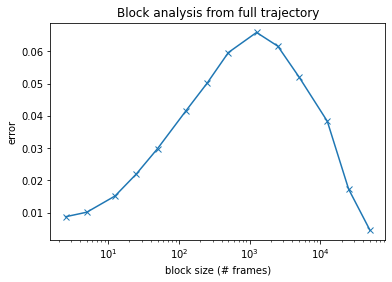

In [9]:
plt.plot(len(colvar_rew) / np.array(nblocks), dd[:,1], "x-")
plt.xscale("log")
plt.title("Block analysis from full trajectory")
plt.xlabel("block size (# frames)")
plt.ylabel("error")
plt.show()

In [20]:
len(colvar_rew) / np.array(nblocks)

array([2.500010e+00, 5.000020e+00, 1.250005e+01, 2.500010e+01,
       5.000020e+01, 1.250005e+02, 2.500010e+02, 5.000020e+02,
       1.250005e+03, 2.500010e+03, 5.000020e+03, 1.250005e+04,
       2.500010e+04, 5.000020e+04])

In [10]:
# analyze second half of trajectory
dd = []
for nb in nblocks:
    dd.append(analyze(colvar_rew, nb, discard=0.5))
dd = np.array(dd)
dd

array([[-3.20058023,  0.01122499],
       [-3.20058023,  0.01241264],
       [-3.20292065,  0.01746575],
       [-3.20292065,  0.02093254],
       [-3.19502413,  0.03145692],
       [-3.20318613,  0.05172173],
       [-3.19502413,  0.06328087],
       [-3.19502413,  0.07989048],
       [-3.19502413,  0.08947536],
       [-3.19502413,  0.0866361 ],
       [-3.19502413,  0.10238465],
       [-3.19502413,  0.07469347],
       [-3.19502413,  0.07463245],
       [-3.19502413,  0.02846076]])

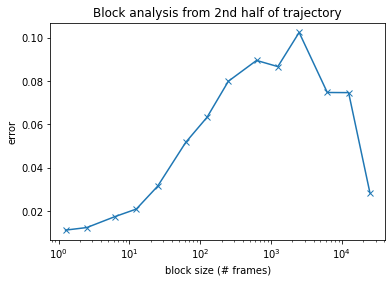

In [11]:
plt.plot(0.5 * len(colvar_rew) / np.array(nblocks), dd[:,1], "x-")
plt.xscale("log")
plt.title("Block analysis from 2nd half of trajectory")
plt.xlabel("block size (# frames)")
plt.ylabel("error")
plt.show()

Best block size seems 2500 frames (~ 100 blocks for the full traj) ~ 50 ps.
Order of magnitude of the error seems consistent with what was reported. In the analysis below we fix this as the block size.

We then read the full dataset: 20 simulations where the potential is kept constant in the last 1 ns. Notice that I will either analyze the last fifth or the fourth fifth of the trajectory. Namely:

- t=4 to 5 ns: potential is static
- t=3 to 4 ns: potential is changing

Obviously, the latter is reprentative of a simulation where UPDATE_UNTIL was not used

In [12]:
colvar_all = []
for i in range(1, 21):
    colvar_all.append(plumed.read_as_pandas("../data/UPDATE_UNTIL/rep_{}/COLVAR_REWEIGHT".format(i)))
    colvar_all[-1].time *= 0.02 # fix time to ps (originally, it was 10 simulation steps)

hills_all = []
for i in range(1, 21):
    hills_all.append(plumed.read_as_pandas("../data/UPDATE_UNTIL/rep_{}/HILLS_LAMBDA".format(i)))

<ipython-input-12-69d5c1014570>:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  colvar_all.append(plumed.read_as_pandas("../data/UPDATE_UNTIL/rep_{}/COLVAR_REWEIGHT".format(i)))
<ipython-input-12-69d5c1014570>:8: UserWarning: cannot load PLUMED instance, conversions will not be available
  hills_all.append(plumed.read_as_pandas("../data/UPDATE_UNTIL/rep_{}/HILLS_LAMBDA".format(i)))


I now analyze all the trajectories. I am using three different approaches:
- use only the static potential fraction (last 1 ns)
- use the 3 to 4 ns fraction, assuming bias has always been the final one (this is the standard reweighting discussed in the tutorial)
- use the 3 to 4 ns fraction, assuming bias has always been the time average of the bias on that interval (this is compulsory when using non-well-tempered metadynamics, and should be recommended with well-tempered metadynamics as well if biasfactor is high)

Notice that the usual trick to obtain the time-averaged potential is to scale hills hight with a factor going lineary to zero from, say t=3 to t=4 ns. This is analytically equivalent to averaging the potential. See the time_average() function above

In [36]:
dd=[]
for i in range(len(colvar_all)):
    df = colvar_all[i]
    # analyze the static potential part
    df1 = df.loc[(df['time'] >= 4000)]
    # analyze 3000-4000 ps assuming the final potential
    df2 = df.loc[(df['time'] <= 4000) & (df['time'] > 3000) ]
    # analyze 3000-4000 ps assuming the time-averaged potential
    df3 = df.loc[(df['time'] <= 4000) & (df['time'] > 3000) ].copy()
    
    # No actions are required for df1 and df2 since the last column in COLVAR_REWEIGHT the last column
    # has been the sum of all biases as a function of lambda state. We need to calculate the time-averaged
    # potential for df3 though.
    df3["metad.bias"] = metad_bias(time_average(hills_all[i]))[np.int_(df3["lambda"])]   
    dd.append((
        analyze(df1, len(df1) // 2500),  # 2500: the number of time frames in one block
        analyze(df2, len(df2) // 2500),
        analyze(df3, len(df3) // 2500))
    )
dd=np.array(dd)
# dd[i,j,k]  (shape: (20, 3, 2))
# i=0..19 (iteration)
# j=0..2 (method)
# k=0..1 (average and stddev)

In [37]:
# reasonable range to show Gaussians
# dd[:, :, 0] and dd[:, :, 1] are the free energy and the error, respectively.
x_min = np.min(dd[:, :, 0]) - 2 * np.max(dd[:, :, 1])  # the lower bound of the range
x_max = np.max(dd[:, :, 0]) + 2 * np.max(dd[:, :, 1])  # the upper bound of the range
x = np.linspace(x_min, x_max, 500)

In [38]:
dd[:, :, 0]   # the free energy of each repetition with 3 different methods

array([[-3.24848774, -3.52410576, -3.28655947],
       [-3.56965871, -3.59506757, -3.52636024],
       [-3.2051578 , -3.97179024, -3.75467124],
       [-3.18943986, -3.31796676, -3.43317831],
       [-3.17441432, -3.2815048 , -3.12978951],
       [-3.38131836, -3.57652975, -3.2046757 ],
       [-3.44947514, -3.5212884 , -3.25364389],
       [-3.30749646, -3.81447846, -3.38608085],
       [-3.30170365, -3.10526109, -3.49154405],
       [-3.4580172 , -3.09568197, -3.23737475],
       [-3.35289218, -3.66042863, -3.57269401],
       [-3.28614087, -2.71305153, -3.14652741],
       [-3.71753698, -2.91135613, -3.33838712],
       [-3.0474602 , -4.52899919, -3.48278654],
       [-3.27370856, -3.68914994, -3.38938897],
       [-3.35019174, -3.86049471, -3.41782762],
       [-3.26818855, -2.90998749, -3.30487342],
       [-3.37888771, -3.83916547, -3.29954513],
       [-2.92299584, -3.45911394, -3.3569404 ],
       [-3.61413078, -3.38799688, -3.44766562]])

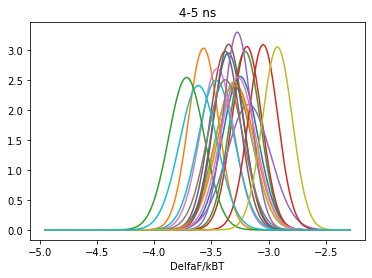

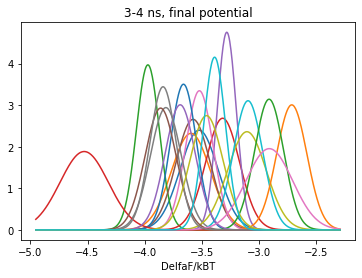

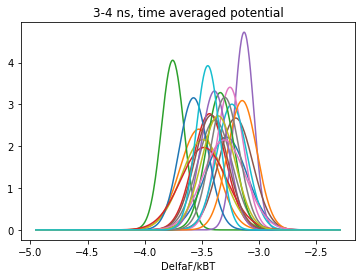

In [16]:
for i in range(len(dd)):
    plt.plot(x, 1 / np.sqrt(2.0 * np.pi * dd[i, 0, 1] ** 2) * np.exp(-0.5 * (x - dd[i, 0, 0]) ** 2 / dd[i, 0, 1] ** 2))
plt.title("4-5 ns")
plt.xlabel("DelfaF/kBT")
plt.show()

for i in range(len(dd)):
    plt.plot(x, 1 / np.sqrt(2.0 * np.pi * dd[i, 1, 1] ** 2) * np.exp(-0.5*(x - dd[i, 1, 0]) ** 2 / dd[i, 1, 1] ** 2))
plt.title("3-4 ns, final potential")
plt.xlabel("DelfaF/kBT")
plt.show()

for i in range(len(dd)):
    plt.plot(x, 1 / np.sqrt(2.0 * np.pi * dd[i, 2, 1] ** 2) * np.exp(-0.5 * (x - dd[i, 2, 0]) ** 2 / dd[i, 2, 1] ** 2))
plt.title("3-4 ns, time averaged potential")
plt.xlabel("DelfaF/kBT")
plt.show()

In [17]:
# in principle, the optimal way to combine all these simulations is to use WHAM
# since they are performed with a different potential
# for simplicity I just take their average here
# I consider this as a reference result, hopefully it is
# consistent with longer reference simulations
reference = np.average(dd[:, 0, 0])

print("Reference value:", reference)
# Z score:
Z = (dd[:, :, 0] - reference) / dd[:, :, 1]  # same shape as dd
print("For each method, rmse of simulations wrt reference and <Z**2> (should be ~ 1)")
print("4-5 ns, with static potential:", np.sqrt(np.sum((dd[:, 0, 0] - reference)**2)), np.sqrt(np.average(Z[:, 0] ** 2)))
print("3-4 ns, with final potential:",np.sqrt(np.sum((dd[:,1,0]-reference)**2)),np.sqrt(np.average(Z[:,1]**2)))
print("3-4 ns, with averaged potential:",np.sqrt(np.sum((dd[:,2,0]-reference)**2)),np.sqrt(np.average(Z[:,2]**2)))

Reference value: -3.324865131689222
For each method, rmse of simulations wrt reference and <Z**2> (should be ~ 1)
4-5 ns, with static potential: 0.803951071335667 1.2591485212095352
3-4 ns, with final potential: 1.990382288484258 3.0817038212875922
3-4 ns, with averaged potential: 0.6954058612188779 1.3716414371629946


First and third method gives comparable results.
Second method gives less accurate result (RMSE~2) but a similar error estimate. Error is thus underestimated.

In [42]:
-3.3430185676865705

-3.3430185676865705

As a note, below shows the uncertainties obtained from each method:

In [18]:
print('Method 1:')
print(dd[:, 0, 1])
print('std: ', np.std(dd[:, 0, 0]))

print('\nMethod 2:')
print(dd[:, 1, 1])
print('std: ', np.std(dd[:, 1, 0]))

print('\nMethod 3:')
print(dd[:, 2, 1])
print('std: ', np.std(dd[:, 2, 0]))

Method 1:
[0.15598049 0.13171372 0.13408331 0.13054368 0.1909147  0.13398466
 0.14829999 0.16531169 0.1611927  0.15986364 0.13522821 0.16540955
 0.15694721 0.1292032  0.12105458 0.12895688 0.15675757 0.15939363
 0.13082915 0.16572675]
std:  0.1797689246090334

Method 2:
[0.16644306 0.17185571 0.1005508  0.14862147 0.08396036 0.15008722
 0.11926359 0.13569307 0.16897815 0.12849748 0.11391581 0.13272621
 0.1270044  0.21172557 0.13265778 0.13625558 0.20421097 0.11593944
 0.14519325 0.09608321]
std:  0.41401968167263925

Method 3:
[0.17977618 0.16555658 0.09831896 0.14358216 0.08436505 0.14909497
 0.1169353  0.15168555 0.18472183 0.13268591 0.12627893 0.12899945
 0.12147963 0.20242996 0.12013877 0.14540049 0.18536522 0.12585043
 0.14632181 0.10158384]
std:  0.14785135762503235
